In [3]:
import pandas as pd;
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


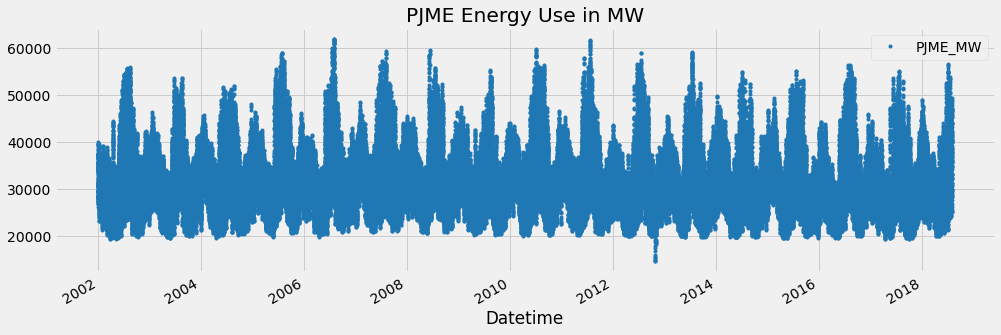

In [4]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='PJME Energy Use in MW');

### Train / Test Split

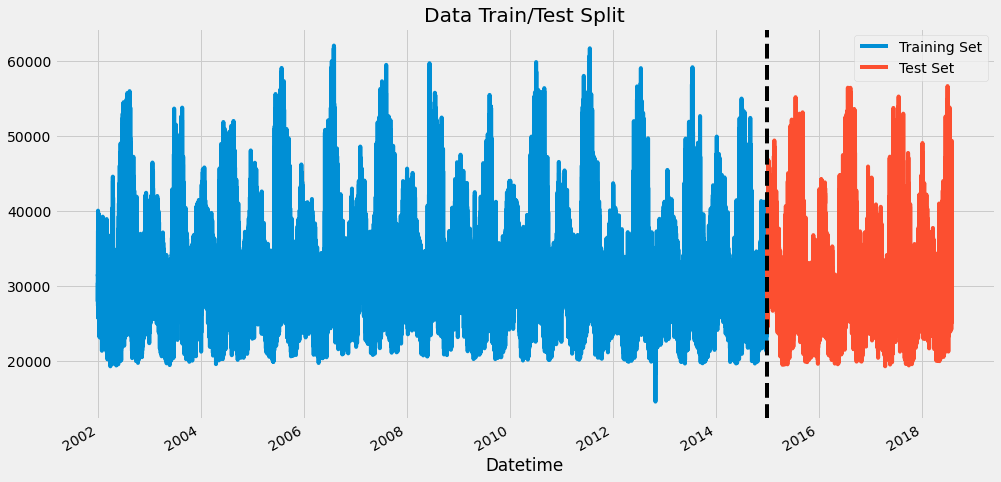

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,8))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

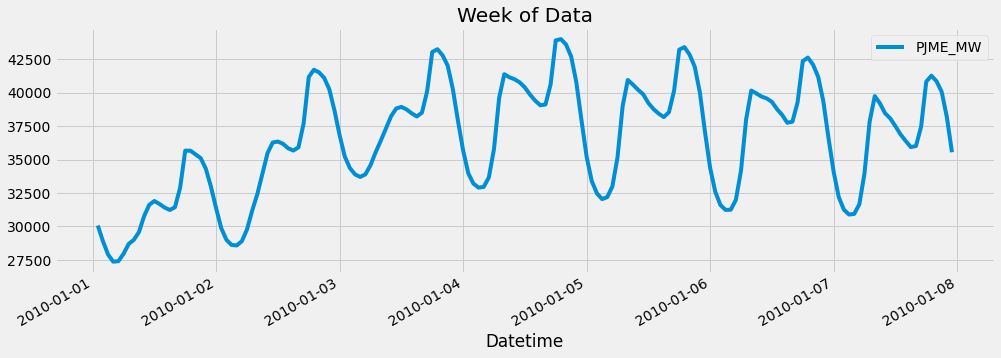

In [6]:
df.loc[((df.index > '01-01-2010') & (df.index < '01-08-2010'))] \
    .plot(figsize=(15,5), title='Week of Data')
plt.show()

#### Feature Creation

In [7]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


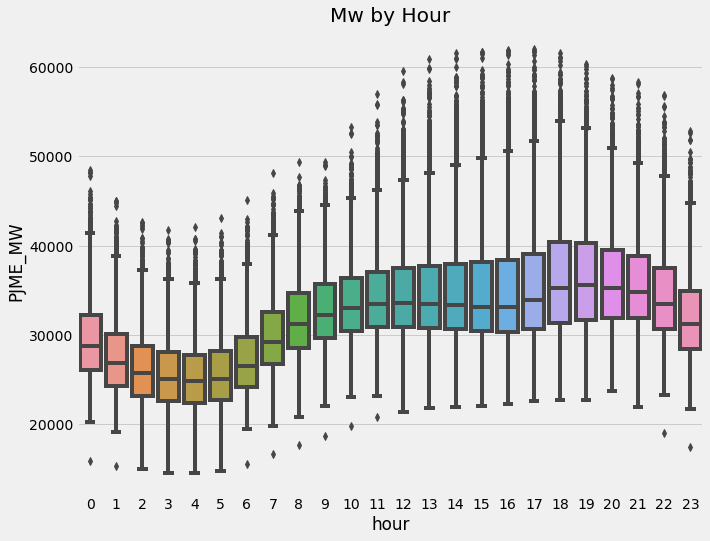

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Mw by Hour')
plt.show();

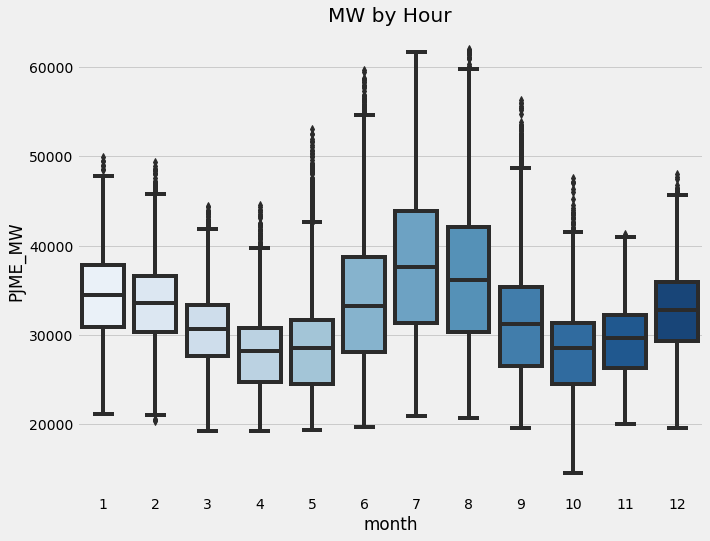

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Hour')
plt.show();

In [10]:
train = create_features(train)
test = create_features(test)

In [11]:
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Create Model

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000, earl_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test,y_test)],
        verbose=100)

[15:24:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "earl_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32894.63672	validation_1-rmse:31946.77148


/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:29802.41211	validation_1-rmse:28850.26758
[200]	validation_0-rmse:27007.67773	validation_1-rmse:26052.45508
[300]	validation_0-rmse:24482.33398	validation_1-rmse:23533.96094
[400]	validation_0-rmse:22201.28711	validation_1-rmse:21261.66992
[500]	validation_0-rmse:20141.58203	validation_1-rmse:19211.95312
[600]	validation_0-rmse:18281.67773	validation_1-rmse:17372.91406
[700]	validation_0-rmse:16603.53125	validation_1-rmse:15717.88184
[800]	validation_0-rmse:15090.23731	validation_1-rmse:14218.24316
[900]	validation_0-rmse:13726.70606	validation_1-rmse:12873.10156
[999]	validation_0-rmse:12510.66016	validation_1-rmse:11683.12207


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, earl_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

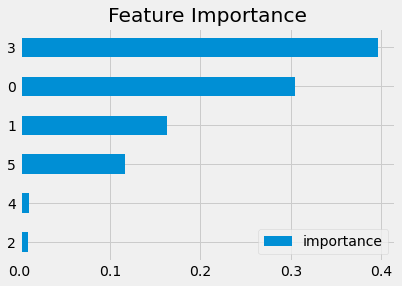

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [15]:
reg.predict(X_test)

array([19649.166, 17742.72 , 17084.219, ..., 22443.951, 21950.154,
       19649.166], dtype=float32)

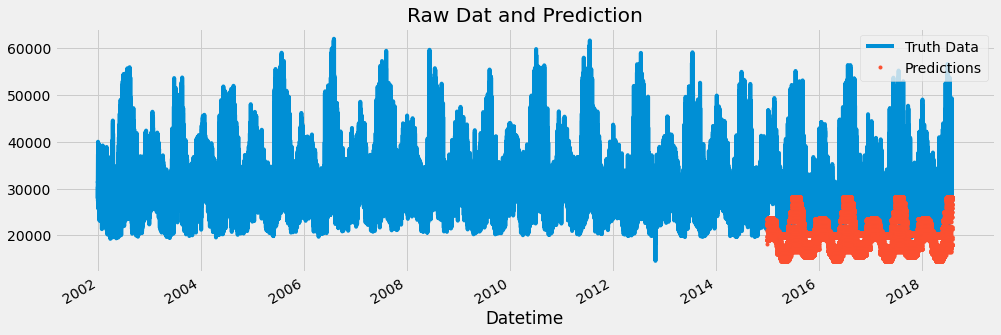

In [16]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

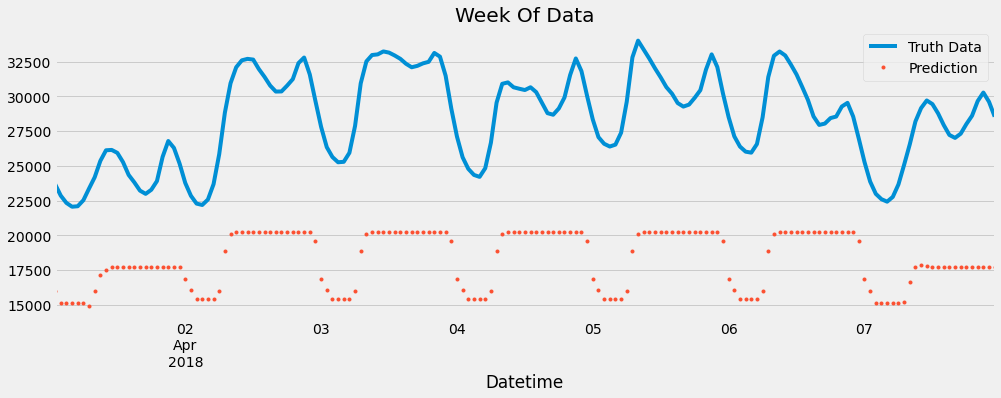

In [17]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [18]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 11683.12


In [19]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    23994.513021
2016-08-14    23319.643636
2018-01-06    22894.469076
2015-02-20    22736.354004
2016-09-10    22422.469279
2016-09-09    22129.154500
2015-02-16    22058.791992
2018-01-05    21897.454102
2016-08-12    21600.026204
2018-01-07    21568.677246
Name: error, dtype: float64

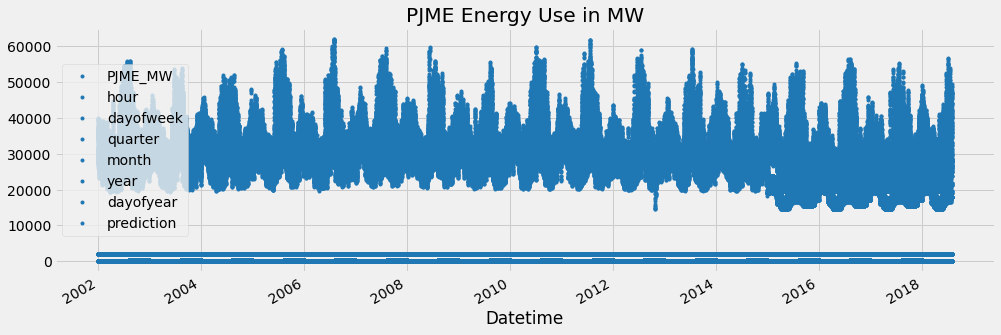

In [20]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

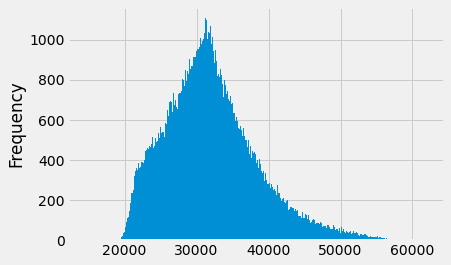

In [28]:
df['PJME_MW'].plot(kind='hist', bins=500);

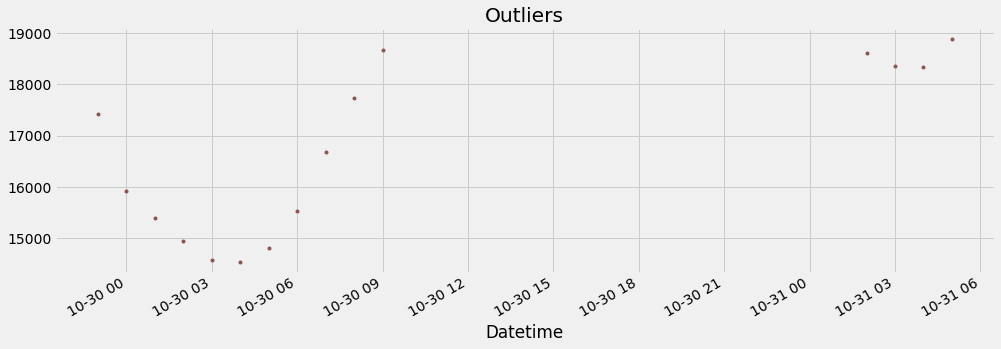

In [27]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
          figsize=(15,5),
          color=color_pal[5],
          title='Outliers');

In [29]:
df = df.query('PJME_MW > 19_000').copy()

### Time Series Cross Validation

In [34]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

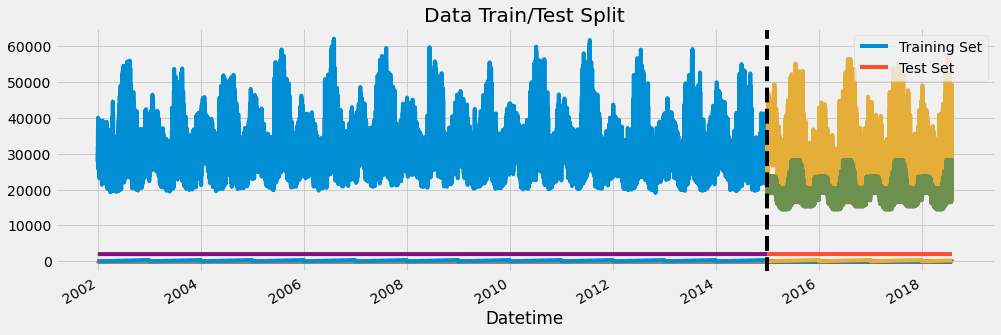

In [35]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

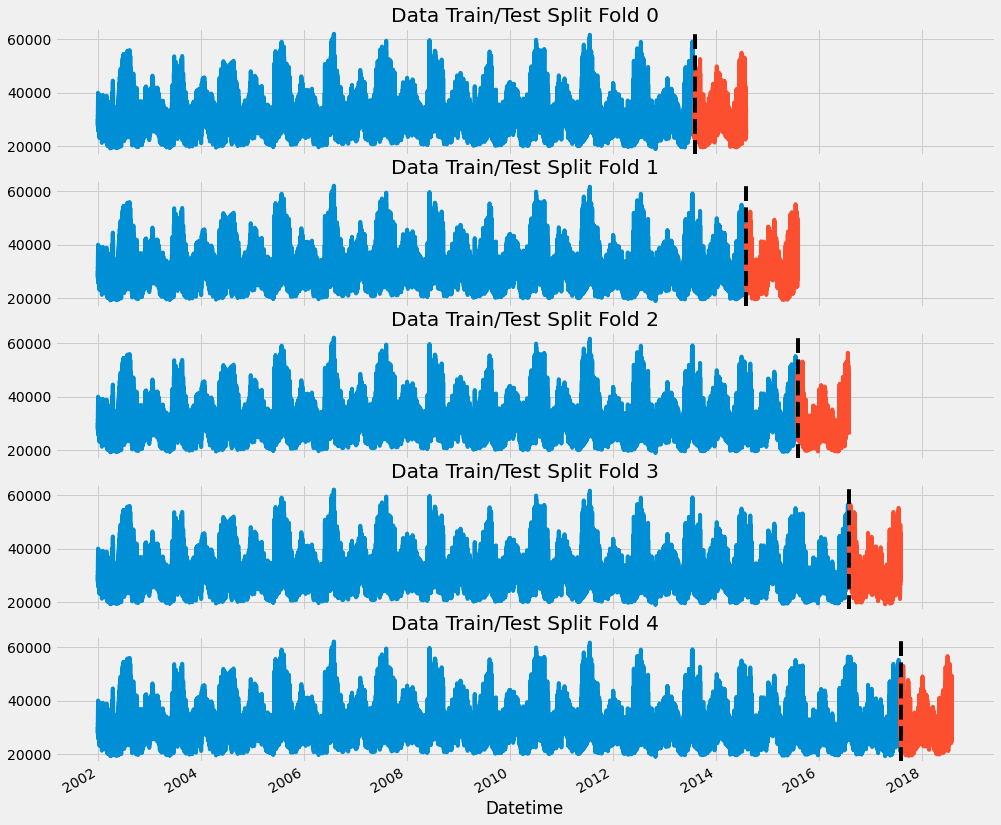

In [36]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Forecasting Time Horizon

In [39]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Lag Features

In [40]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [41]:
df = add_lags(df)

### Train Using Cross Validation

In [42]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[17:23:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32732.30469	validation_1-rmse:31956.19141


/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12532.09277	validation_1-rmse:11907.30957
[200]	validation_0-rmse:5741.74902	validation_1-rmse:5353.56348
[300]	validation_0-rmse:3867.58447	validation_1-rmse:3890.84106
[400]	validation_0-rmse:3430.05835	validation_1-rmse:3753.97046
[500]	validation_0-rmse:3313.44824	validation_1-rmse:3767.99658
[600]	validation_0-rmse:3257.11255	validation_1-rmse:3781.85644
[700]	validation_0-rmse:3217.38794	validation_1-rmse:3791.59644
[800]	validation_0-rmse:3182.34082	validation_1-rmse:3799.20581
[900]	validation_0-rmse:3152.73731	validation_1-rmse:3789.42993
[999]	validation_0-rmse:3120.67871	validation_1-rmse:3782.09253
[17:24:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/

/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12513.15430	validation_1-rmse:12224.63379
[200]	validation_0-rmse:5754.32568	validation_1-rmse:5658.62353
[300]	validation_0-rmse:3902.51147	validation_1-rmse:3935.24365
[400]	validation_0-rmse:3475.66162	validation_1-rmse:3601.97949
[500]	validation_0-rmse:3354.59619	validation_1-rmse:3533.03345
[600]	validation_0-rmse:3298.02026	validation_1-rmse:3496.44971
[700]	validation_0-rmse:3258.22241	validation_1-rmse:3470.85840
[800]	validation_0-rmse:3223.87500	validation_1-rmse:3449.40308
[900]	validation_0-rmse:3197.08618	validation_1-rmse:3441.58301
[999]	validation_0-rmse:3169.63599	validation_1-rmse:3432.69458
[17:25:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/

/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12498.42578	validation_1-rmse:11130.58301
[200]	validation_0-rmse:5748.66553	validation_1-rmse:4806.84424
[300]	validation_0-rmse:3913.33667	validation_1-rmse:3543.68042
[400]	validation_0-rmse:3490.60230	validation_1-rmse:3489.14624
[500]	validation_0-rmse:3375.66211	validation_1-rmse:3548.40527
[600]	validation_0-rmse:3317.00830	validation_1-rmse:3594.07227
[700]	validation_0-rmse:3274.64819	validation_1-rmse:3625.31665
[800]	validation_0-rmse:3243.15625	validation_1-rmse:3659.89697
[900]	validation_0-rmse:3216.79712	validation_1-rmse:3695.42505
[999]	validation_0-rmse:3191.54077	validation_1-rmse:3715.28857
[17:26:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/

/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12461.64844	validation_1-rmse:12017.21387
[200]	validation_0-rmse:5736.46826	validation_1-rmse:5792.72119
[300]	validation_0-rmse:3913.95117	validation_1-rmse:4383.20117
[400]	validation_0-rmse:3495.38306	validation_1-rmse:4171.92871
[500]	validation_0-rmse:3380.41480	validation_1-rmse:4123.13086
[600]	validation_0-rmse:3321.61377	validation_1-rmse:4110.08643
[700]	validation_0-rmse:3282.18262	validation_1-rmse:4093.73975
[800]	validation_0-rmse:3249.60693	validation_1-rmse:4091.92676
[900]	validation_0-rmse:3220.99048	validation_1-rmse:4086.00806
[999]	validation_0-rmse:3195.27563	validation_1-rmse:4065.53101
[17:27:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/

/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12445.03125	validation_1-rmse:11959.38769
[200]	validation_0-rmse:5750.30029	validation_1-rmse:5617.38574
[300]	validation_0-rmse:3950.17114	validation_1-rmse:4150.43115
[400]	validation_0-rmse:3538.55811	validation_1-rmse:3995.73120
[500]	validation_0-rmse:3427.91382	validation_1-rmse:4026.43359
[600]	validation_0-rmse:3371.26782	validation_1-rmse:4050.99243
[700]	validation_0-rmse:3333.89673	validation_1-rmse:4052.71167
[800]	validation_0-rmse:3303.19507	validation_1-rmse:4048.33179
[900]	validation_0-rmse:3275.01050	validation_1-rmse:4044.00366
[999]	validation_0-rmse:3252.79150	validation_1-rmse:4031.25317


In [43]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3805.3721
Fold scores:[3782.0923619296236, 3432.6947233055266, 3715.2885243911232, 4065.5311560120344, 4031.2537502094615]


### Predicting the Future

In [44]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[17:27:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.50195


/Users/mattsaltzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12426.29297
[200]	validation_0-rmse:5751.87793
[300]	validation_0-rmse:3970.81934
[400]	validation_0-rmse:3570.29688
[499]	validation_0-rmse:3455.03223


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [45]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [46]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [47]:
future_w_features = df_and_future.query('isFuture').copy()

### Predict the Future

In [48]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


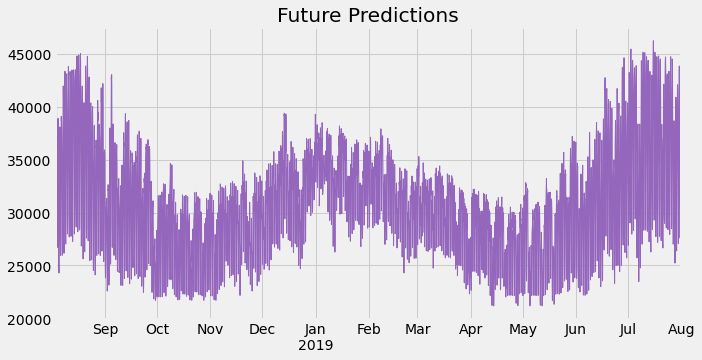

In [49]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()


### Save Model

In [50]:
reg.save_model('model.json')
!ls -lh


total 118112
-rw-rw-r--@  1 mattsaltzman  staff   3.2M Oct  4  2019 AEP_hourly.csv
-rw-r--r--@  1 mattsaltzman  staff   610K Oct 30 21:59 AEP_hourly.csv.zip
-rw-rw-r--@  1 mattsaltzman  staff   1.8M Oct  4  2019 COMED_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   3.1M Oct  4  2019 DAYTON_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   1.5M Oct  4  2019 DEOK_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   3.1M Oct  4  2019 DOM_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   3.1M Oct  4  2019 DUQ_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   1.2M Oct  4  2019 EKPC_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   1.6M Oct  4  2019 FE_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   1.5M Oct  4  2019 NI_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   3.9M Oct  4  2019 PJME_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   3.7M Oct  4  2019 PJMW_hourly.csv
-rw-rw-r--@  1 mattsaltzman  staff   900K Oct  4  2019 PJM_Load_hourly.csv
-rw-r--r--   1 mattsaltzman  staff   930K Oct 31 17:29 Untitl

<AxesSubplot:title={'center':'Future Predictions'}>

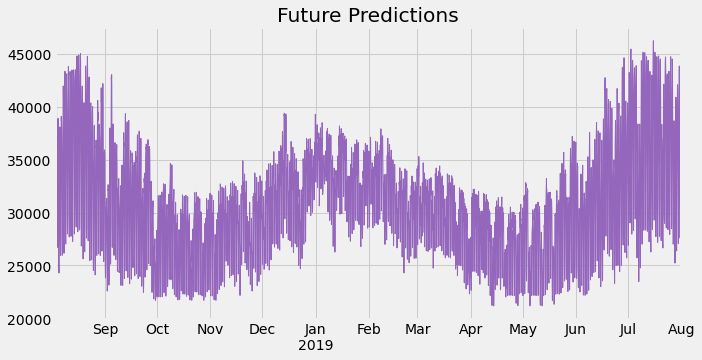

In [51]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')